# Roadmap -- Distortion

This is the real dataset test of [Experiment Distortion](https://github.com/ZhiruiFeng/explorer/blob/master/test/RandomGraph.ipynb).

Here we have our dataset from [DIMACS](http://www.diag.uniroma1.it/challenge9/).

Then we will analysis the distortion on this graph as what we have done on random graph.

In [1]:
# Add libraries
%load_ext autoreload
%autoreload 2
import os, sys
lib_path = os.path.abspath(os.path.join('../'))
sys.path.append(lib_path)

import heuristic.fastmap.utils as utils
from heuristic.fastmap.difastmap import init_dis_store, difastmap_average, difastmap_diff, difastmap_max 
import heuristic.fastmap.analyse as analyse

import matplotlib.pyplot as plt
import networkx as nx
import random
import multiprocessing as mp
import numpy as np
import math
from random import sample

**Load the graph**

In [8]:
filepath = "../data/roadmap/rome99.road"

def readDiGraph_type(infile):
    G = nx.DiGraph()
    with open(infile) as f:
        l = f.readline()
        while l:
            if l[0] != 'a':
                l = f.readline()
                continue
            items = l.strip().split()
            if len(items) == 4:
                node1, node2, weight = items[1:]
            elif len(items) == 3:
                node1, node2 = items[1:]
                wight = 1.0
            G.add_edge(node1, node2, weight=float(weight))
            l = f.readline()
    return G

In [30]:
G = readDiGraph_type(filepath)
utils.connectivity_info(G)
print(G.number_of_nodes())
print(G.number_of_edges())

A strongly connected graph.
3353
8859


In [24]:
def thedistance_info(G):
    dis = []
    span = G.number_of_nodes() / 100
    nodelist = list(G.nodes())
    for i in range(G.number_of_nodes()):
        if i%(span) == 0:
            sys.stdout.write("\r {}%".format(int(i/span)))
        length = nx.single_source_dijkstra_path_length(G, nodelist[i])
        dis.extend(list(length.values()))
    plt.hist(dis)
    plt.xlabel('distance')
    plt.ylabel('count (persents)')
    plt.title('Statistic of pair distances')
    plt.show()

 0%

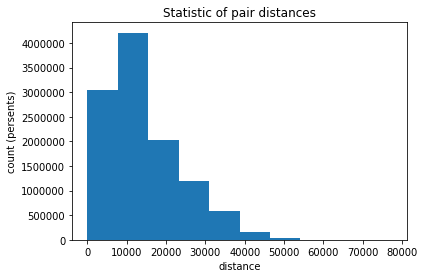

In [26]:
thedistance_info(G)

In [27]:
def meta_distortion(i):
    global G, embedding, subset, alg, variant
    node_1=subset[i]
    emb_1 = np.array(embedding[node_1])
    length = nx.single_source_dijkstra_path_length(G, node_1)
    sigma = 0
    ave_d = 0
    for j in range(i+1, len(subset)):
        node_2 = subset[j]
        emb_2 = np.array(embedding[node_2])
        distance = length[node_2]
        if variant == 'undirected':
            target_dis = distance
        elif variant == 'average':
            distance_reverse = nx.dijkstra_path_length(G, node_2, node_1)
            target_dis = (float(distance) + float(distance_reverse))/2
        elif variant == 'max':
            distance_reverse = nx.dijkstra_path_length(G, node_2, node_1)
            target_dis = max(float(distance), float(distance_reverse))
        elif variant == 'diff':
            distance_reverse = nx.dijkstra_path_length(G, node_2, node_1)
            target_dis = abs(float(distance) - float(distance_reverse))/2
        if alg == 'L1':
            embdis = np.sum(np.abs(emb_1-emb_2))
        elif alg == 'L2':
            embdis = math.sqrt(np.dot(emb_1-emb_2, emb_1-emb_2))
        sigma += (target_dis-embdis)*(target_dis-embdis)
        ave_d += target_dis
    return [sigma, ave_d]

def distortion_mp(G, embedding, subset, alg, variant):
    input_set = list(range(len(subset)))
    sigma = 0
    ave_d = 0
    pool_size = mp.cpu_count() * 2
    print("Pool size: {}".format(pool_size))
    pool = mp.Pool(processes=pool_size)
    pool_outputs = pool.map(meta_distortion, input_set)
    pool.close()
    pool.join()
    # Sum the result of metacalculation
    pool_outputs = np.array(pool_outputs)
    #print(pool_outputs)
    sigma, ave_d = np.sum(pool_outputs, 0)
    base = float(S)*float(S-1)/2
    sigma = math.sqrt(float(sigma)/base)
    ave_d = float(ave_d)/base
    return float(sigma)/ave_d

## Distortion of embedding average

In [ ]:
klist = [3, 7, 11, 15, 19]
for K in klist:
    print("#########Test for K:{}".format(K))
    epsilon = 0.01
    alg = 'L2'
    dis_store = init_dis_store(G)
    embedding = difastmap_average(G, K, epsilon, dis_store, alg)
    S = int(0.2*len(list(G.nodes())))
    subset = sample(list(G.nodes()), S)
    variant = 'average'
    results = distortion_mp(G, embedding, subset, alg, variant)
    print(results)